In [126]:
import requests
from bs4 import BeautifulSoup
import inspect
import json
import os   
from pathlib import Path
import pandas as pd
import re
import io
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import soundfile as sf


<h3>Neste trecho, uma url é analisada, retornando uma série de códigos de aves </h3>    

<p>Ainda não está finalizado. A ideia final é criar um algorítmo que possa iterar pela página, mapeando as espécies e jogando elas dentro da minha máquina</p>

In [ ]:
def selectAves(FamiliaSelect):

    urlInfo="https://www.wikiaves.com.br/especies.php?t=t"

    # Está parte acessa a lista de espécies do wiki aves direto da página

    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/121.0.0.0 Safari/537.36"
        ),
        "Accept-Language": "pt-BR,pt;q=0.9",
        "Referer": "https://www.wikiaves.com.br/"
    }

    responseInfo = requests.get(urlInfo, headers=headers)
    soup = BeautifulSoup(responseInfo.content, "html.parser")

    soup = soup.find_all("table", class_="wa-table-sp table m-table m-table--head-separator-metal wa-table-hover")[0]
    aves = soup.find("tbody").find_all("script")[1:]

    # A lista das espécies está misturada com código html
    # Este trecho serve para limpar esta lista e transforma-la
    # em um dataframe pandas organizado

    avesDf = []

    # iteramos por item dentro do html
    for script in aves:
        texto = script.get_text(strip=True)
        
        # removemos a função "lsp" do html
        match = re.search(r"lsp\((.*)\);", texto)

        valores = []

        # fazemos separação dos valores por ,
        for v in match.group(1).split(","):
            v.strip().strip("'") 
            valores.append(v)

        # A listagem das espécies no site não lista a família da ave em todos os registros
        # apenas no primeiro registro que identifica aquela família, por isso o replicamos
        # para que no meu dataframe tenhamos a família da ave colocada corretamente nas colunas
        if valores[1] != " ''":
            familiaAtual = valores[1]

        else:
            valores[1] = familiaAtual
        
        avesDf.append({
            "codigo": int(valores[0].strip().strip("'")),
            "familia": valores[1].strip().strip("'") or None,
            "nome_cientifico": valores[2].strip().strip("'"),
            "nome_popular": valores[3].strip().strip("'"),
            "slug": valores[4].strip().strip("'"),
            "fotos": int(valores[5]),
            "sons": int(valores[6]),
        })

    avesDf = pd.DataFrame(avesDf)

    FamiliaSelect = "Columbidae"

    avesSelect = avesDf[
        (avesDf["familia"] == FamiliaSelect) &
        (avesDf["sons"] > 100)
    ][["codigo", "nome_popular"]]

    return avesSelect

<h3>função de pré processamento, para facilitar a leitura do código</h3>

In [ ]:
def preProcess(audio, sr):
    TARGET_SECONDS = 5

    # Calcula a média quadrática para detectar evento principal
    # Esse código desloca uma janela de amostragem pelo áudio 
    # calculando a média de energia, assim podemos saber qual é 
    # o trecho com mais atividade
    rms = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)[0]

    # Pegamos o trecho com mais atividade do retorno da função
    # e então aplicamos essa multiplicação para removermos os 20%
    # menos relevante do audio, assim eliminando uma faixa de ruído
    threshold = 0.2 * np.max(rms)

    # Frames onde há evento sonoro relevante
    frames_event = np.where(rms > threshold)[0]

    # Converte frames para amostras
    start_sample = librosa.frames_to_samples(frames_event[0], hop_length=512)
    end_sample = librosa.frames_to_samples(frames_event[-1], hop_length=512)

    # Extrai somente o evento principal
    audio_event = audio[start_sample:end_sample]
    target_samples = TARGET_SECONDS * sr

    if len(audio_event) < target_samples:
        audio_event = librosa.util.fix_length(audio_event, size=target_samples)
    else:
        audio_event = audio_event[:target_samples]

    audio = audio_event
    return audio

<h3>Aqui pegamos um código de ave diretamente, e então o transformamos em uma pasta com todos os seus sons disponíveis.</h3>

In [ ]:
def createDatasetAudio(codigoAve, nomeAve, dwldLimit):
    # Essa url chama o endpoint /getRegistrosJSON.php
    # Os seus parâmetros, não conheço os detalhes de todos ainda
    # no entanto, eu sei que tm=s significa tipo mídia = som

    urlFiles = "https://www.wikiaves.com.br//getRegistrosJSON.php?tm=s&t=s&s="+str(codigoAve)+"&o=mp&o=mp&p=1"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/121.0.0.0 Safari/537.36"
        ),
        "Accept-Language": "pt-BR,pt;q=0.9",
        "Referer": "https://www.wikiaves.com.br/"
    }

    responseFiles = requests.get(urlFiles, headers=headers)

    cont = 0

    data = json.loads(responseFiles.text)["registros"]["itens"]

    if not Path("../dataset/"+nomeAve).exists(): os.makedirs("../dataset/"+nomeAve)

    for registro in data:
        link = data[registro]["link"]

        # ainda não descobri como pegar diretamente o link dos sons em mp3,
        # ao invés dos espectogramas diretamente, por isso, ao substituir
        # na url mp3 por jpg, podemos pegar os sons brutos
        link = link.replace(".jpg", ".mp3")

        # por algum motivo, os links do s3 bucket com # são protegisdos,
        # e sem o # são totalmente livres
        link = link.replace("#", "")

        # Precisamos de um try, pois alguns downloads tiveram problemas 
        try:
            responseAudio = requests.get(link, timeout=10)
            audio, sr = librosa.load(
                io.BytesIO(responseAudio.content),
                sr=None
            )

            audio = preProcess(audio, sr)
                
        except Exception as e:
            print(f"Erro no arquivo {registro}: {e}")
            continue

        path = Path("..") / "dataset" / f"{nomeAve}" / f"{nomeAve}_{cont}.wav"
        
        sf.write(path, audio, sr)

        if cont >= dwldLimit:
            break

        cont+=1

<h3>Aqui pegamos um código de ave diretamente, e então o transformamos em uma pasta com todos os seus sons disponíveis em formato npy</h3>

In [ ]:
def createDataset(codigoAve, nomeAve, dwldLimit):
    # Essa url chama o endpoint /getRegistrosJSON.php
    # Os seus parâmetros, não conheço os detalhes de todos ainda
    # no entanto, eu sei que tm=s significa tipo mídia = som

    urlFiles = "https://www.wikiaves.com.br//getRegistrosJSON.php?tm=s&t=s&s="+str(codigoAve)+"&o=mp&o=mp&p=1"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/121.0.0.0 Safari/537.36"
        ),
        "Accept-Language": "pt-BR,pt;q=0.9",
        "Referer": "https://www.wikiaves.com.br/"
    }

    responseFiles = requests.get(urlFiles, headers=headers)

    cont = 0

    data = json.loads(responseFiles.text)["registros"]["itens"]

    if not Path("../dataset/"+nomeAve).exists(): os.makedirs("../dataset/"+nomeAve)

    for registro in data:
        link = data[registro]["link"]

        # ainda não descobri como pegar diretamente o link dos sons em mp3,
        # ao invés dos espectogramas diretamente, por isso, ao substituir
        # na url mp3 por jpg, podemos pegar os sons brutos
        link = link.replace(".jpg", ".mp3")

        # por algum motivo, os links do s3 bucket com # são protegisdos,
        # e sem o # são totalmente livres
        link = link.replace("#", "")

        # Precisamos de um try, pois alguns downloads tiveram problemas 
        try:
            responseAudio = requests.get(link, timeout=10)
            audio, sr = librosa.load(
                io.BytesIO(responseAudio.content),
                sr=None
            )

            audio = preProcess(audio, sr)
                
        except Exception as e:
            print(f"Erro no arquivo {registro}: {e}")
            continue

        stft = librosa.stft(
            audio,
            n_fft=2048,      # tamanho da FFT
            hop_length=512   # avanço da janela
        )

        stft_mag = np.abs(stft) 
        stft_db = librosa.amplitude_to_db(stft_mag, ref=np.max)
        path = Path("..") / "dataset" / f"{nomeAve}" / f"{nomeAve}_{cont}.jpg"
        
        np.save(path.with_suffix(".npy"), stft_db)

        if cont >= dwldLimit:
            break

        cont+=1

Vamos usar a função que criamos, e iterar por avesSelect, assim fazedndo os downloads

In [131]:
avesSelect = selectAves("Columbidae")

for x in range(0, len(avesSelect)):
    createDatasetAudio(avesSelect.iloc[x]["codigo"], avesSelect.iloc[x]["nome_popular"], 10)
    createDataset(avesSelect.iloc[x]["codigo"], avesSelect.iloc[x]["nome_popular"], 10)



Erro no arquivo 2: Error opening <_io.BytesIO object at 0x000001D80DBCC3B0>: Format not recognised.
Erro no arquivo 2: Error opening <_io.BytesIO object at 0x000001D806C8D4A0>: Format not recognised.
Erro no arquivo 3: Error opening <_io.BytesIO object at 0x000001D80DBCC400>: Format not recognised.
Erro no arquivo 3: Error opening <_io.BytesIO object at 0x000001D80D5014A0>: Format not recognised.
Erro no arquivo 1: Error opening <_io.BytesIO object at 0x000001D80DBCCC20>: Format not recognised.
Erro no arquivo 1: Error opening <_io.BytesIO object at 0x000001D80C45A3B0>: Format not recognised.
Erro no arquivo 5: Error opening <_io.BytesIO object at 0x000001D80CF6C0E0>: Format not recognised.
Erro no arquivo 8: Error opening <_io.BytesIO object at 0x000001D80C4B16D0>: Format not recognised.
Erro no arquivo 5: Error opening <_io.BytesIO object at 0x000001D80D7ECE50>: Format not recognised.
Erro no arquivo 8: Error opening <_io.BytesIO object at 0x000001D80C45A3B0>: Format not recognised.


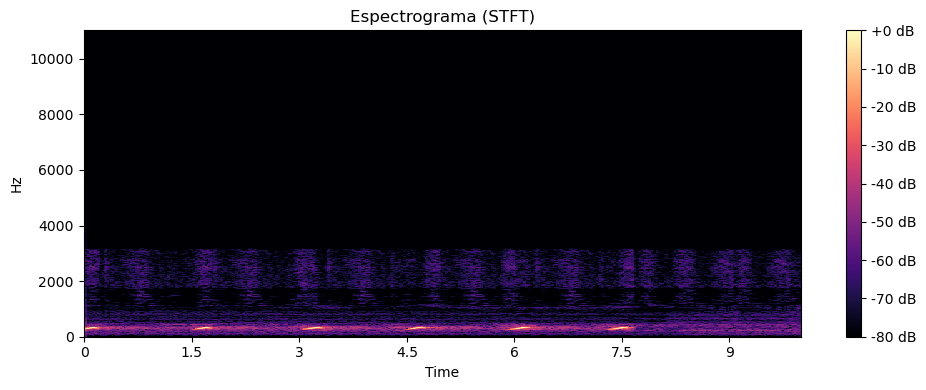

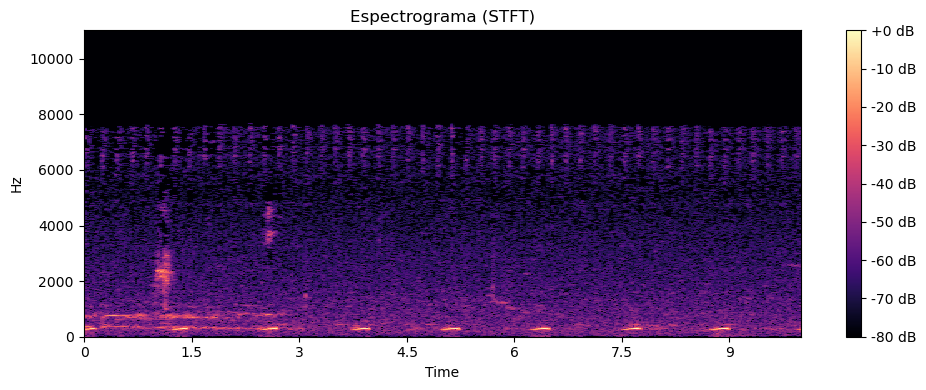

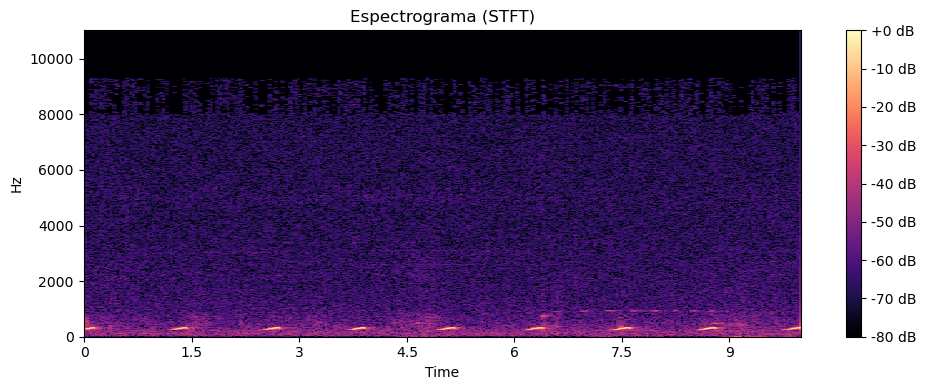

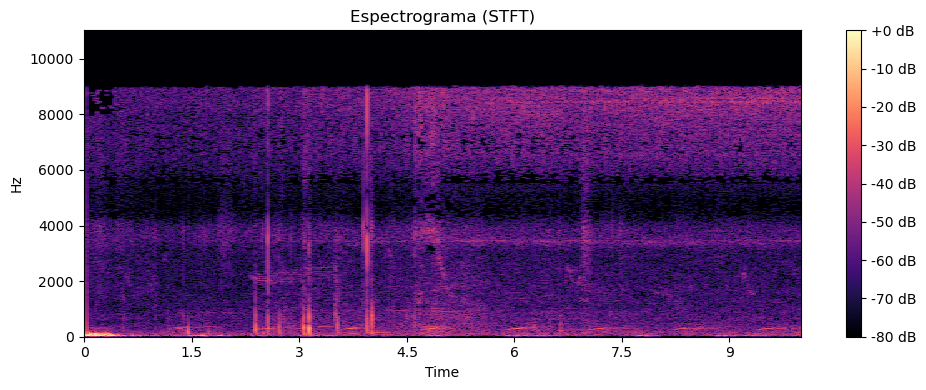

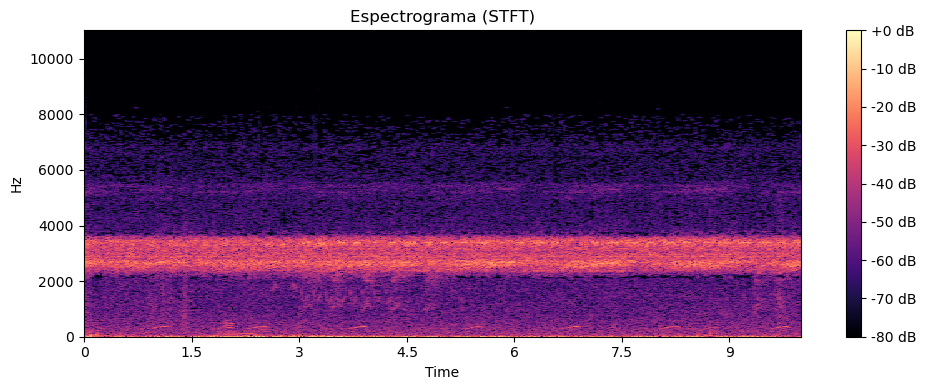

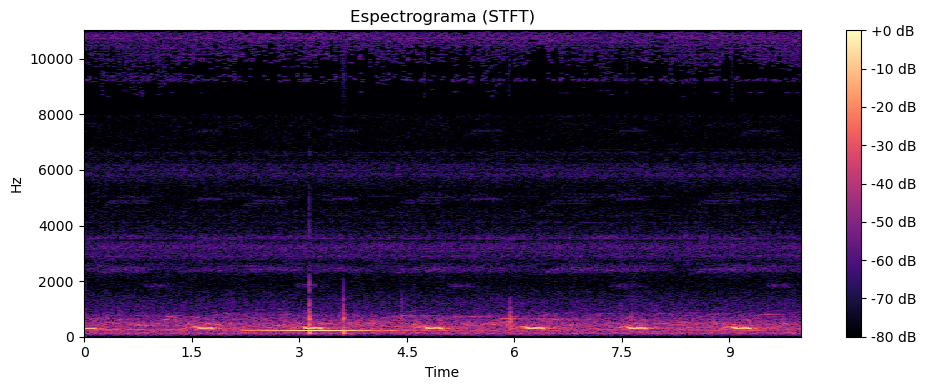

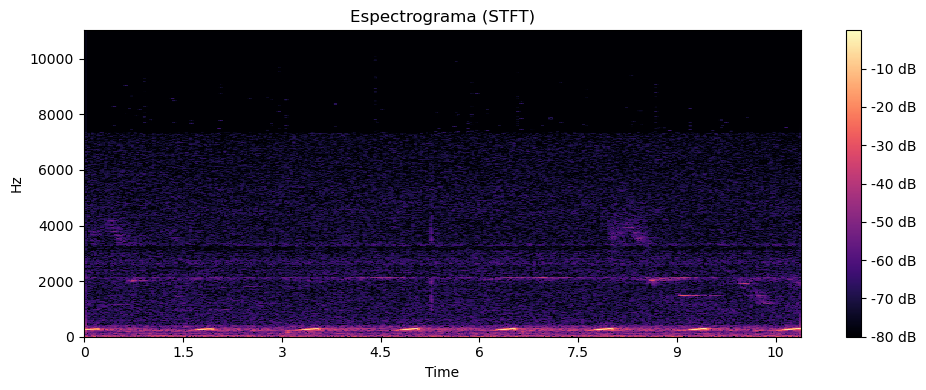

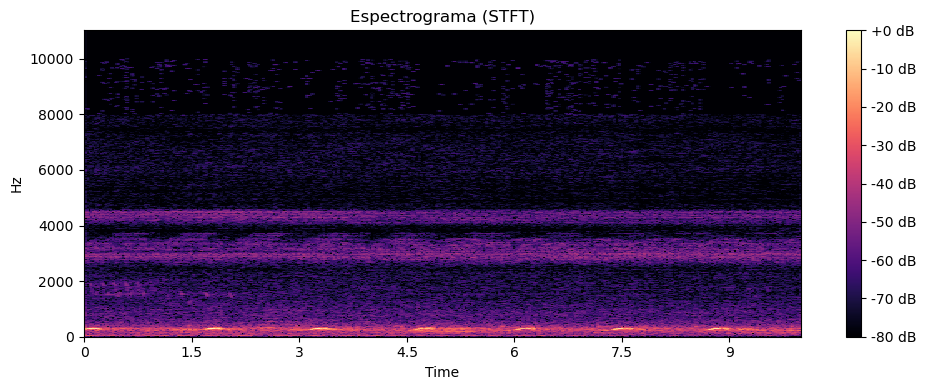

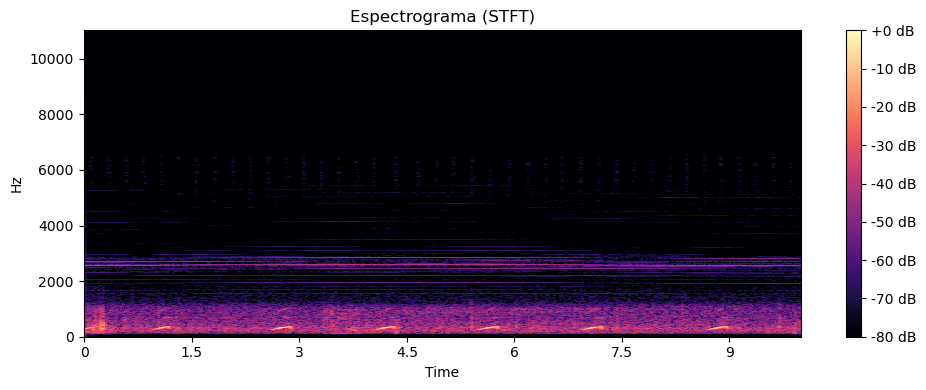

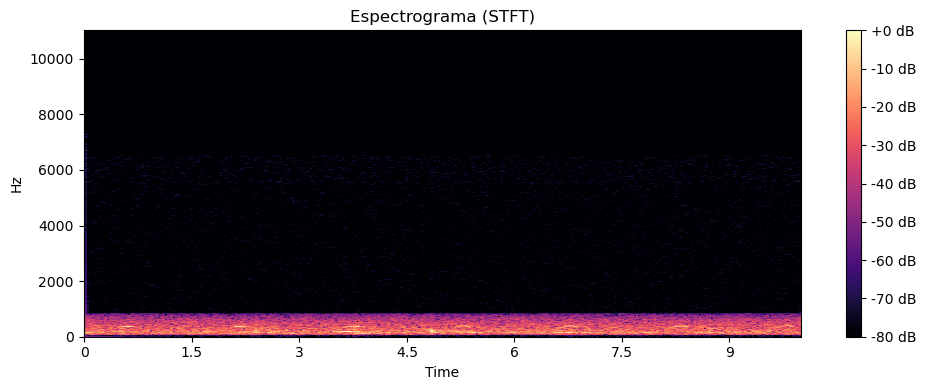

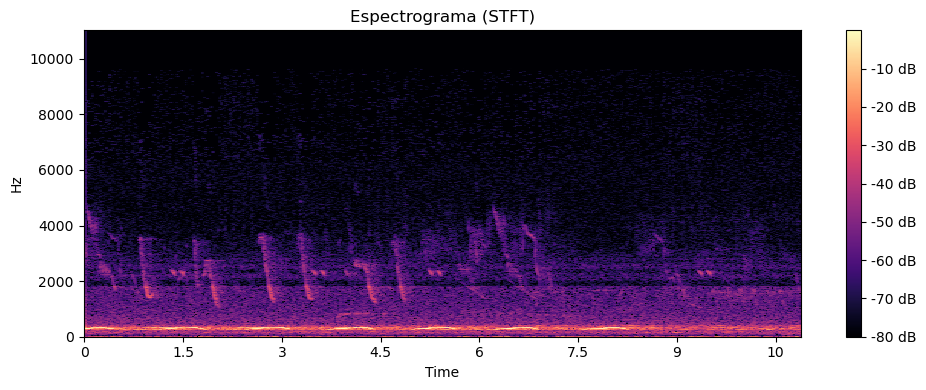

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# pasta onde estão os .npy
DATASET_DIR = Path("../dataset/rolinha-de-asa-canela")

# lista todos os arquivos .npy
files = sorted(DATASET_DIR.glob("*.npy"))

for file in files:
    spec = np.load(file)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        spec,
        #sr=sr,
        hop_length=512,
        x_axis="time",
        y_axis="hz"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Espectrograma (STFT)")
    plt.tight_layout()
    plt.show()
